# **SINF - 02) Analysis of variance (ANOVA)**

A group of statistica techniques that test the dofference of means between groups. ANOVA testing is useful when is wanted to test a hypothesis about group differences based on ctegorical independent variables. The intuition begind ANOVA is to compare the variability BETWEEN different groupswith the variability WITHIN the groups. If they are comparable, then the differences between groups are more likely to be due to sampling variability. The variation between and within groups is calculated as sums of squares, which are then expressed as a ratio. The ratio is known as the F-statistic.

**References:**  
Google Advanced Data Analytics Certificate. Course 5 Module 3

## **2.1) Define a dataset**

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.stats.multicomp as multi

In [2]:
# Define parameters
mean_1 = 80
mean_2 = 90
mean_3 = 90
std = 5

# Create dataframe
df_data = pd.DataFrame({"Program": ["A"]*4 + ["B"]*4 + ["C"]*4,
    "Score": np.concatenate([stats.norm.rvs(mean_1,std,4), stats.norm.rvs(mean_2, std, 4), stats.norm.rvs(mean_3, std, 4)]).round(0)},
    index=[i for i in range(1,13)])
df_data.index.name = "Student"

# Block breaker
print("="*100)
print(df_data)
print("="*100)

        Program  Score
Student               
1             A   82.0
2             A   69.0
3             A   84.0
4             A   81.0
5             B   89.0
6             B   95.0
7             B   95.0
8             B   79.0
9             C   84.0
10            C   91.0
11            C   86.0
12            C   90.0


## **2.2) One-way ANOVA**

Compares the means of one continuous dependent variable based on three or more groups of **one** categorical variable.

Given three groups $\{A, B, C\}$, the null hypothesis states that the mean for all groups is the same. If only one mean differs, is sufficient evidence to reject the null hypothesis. The alternative hypothesis states that not all the means are equal.

> $H_0: \mu_A = \mu_B = \mu_C$  
> $H_1: \mu_i \neq \mu_j$ $\textit{for at least one pair of i,j}$

The test statistic is computed as follows and it's compared to the F-distribution:
> $F = \dfrac{MSSB}{MSSW} \sim \displaystyle F_{(k-1,n-k)}$

Where:  
> $MSSB = \dfrac{SSB}{k-1} \quad$ and $\quad SSB = \displaystyle \sum_{g=1}^k n_g(M_g - M_G)^2 \qquad$ Given that there are $k$ groups. $n_g$ is the numebr of elements in group $g$ , $M_g$ is the mean within group $g$ and $M_G$ is the mean of all the elements within all groups.
>     
> $MSSW = \dfrac{SSW}{n-k} \quad$ $\quad SSW = \left[ \displaystyle \sum_{g=1}^k \sum_{i=1}^{n_g} (x_{gi} - M_g)^2 \right] - SSB$

**Assumptions:**  
> - **The dependent values for each group come from normal distributions**  
_Note that this does NOT mean that all of the dependent values, taken together, must be normally distributed._  
> - **The variances across groups are equal**  
_The variance around the means of each group is the same for all of them_  
> - **Observations are independent of each other**  
_Assumes that one obdservation does not influence or predict any other observation._

In [3]:
# Number of groups and number of observations
k = df_data["Program"].unique().shape[0]
n = df_data.shape[0]

# Compute mean sum of squares BETWEEN groups
mean_by_group = df_data.groupby("Program").mean().values
count_by_group = df_data.groupby("Program").count().values
mean = df_data["Score"].mean()
ssb = ((mean_by_group - mean)**2 * count_by_group).sum()
mssb =  ssb / (k-1)

# Compute mean sum of squares WITHIN groups
ssw = (((df_data["Score"] - mean)**2).sum() - ssb)
mssw = ssw / (n-k)

# Compute F statistic and pvalue
stat = mssb / mssw
pvalue = 1 - stats.f(dfn=k-1, dfd=n-k).cdf(stat)

# Block breaker
print("="*100+"\npvalue: {:.4f}\nThus, the null hypothesis is  rejected".format(pvalue),
      "\nIt means that not all the means are equal" 
      ,"\n"+"="*100)

pvalue: 0.0825
Thus, the null hypothesis is  rejected 
It means that not all the means are equal 


## **2.3) Use of libraries**

Statsmodels offers predefined funtion to compute one way ANOVA. Note that an OLS model need to be fit in the first place.

In [4]:
# Adjust model and run one way ANOVA
model = ols(formula = "Score ~ Program", data=df_data).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
Program,253.166667,2.0,3.333577,0.082535
Residual,341.750000,9.0,NaN,NaN


## **2.4) Two-way ANOVA**

Is a statistical technique used to analyze the impact of two independent categorical variable (factors) on a continuous depndent variable. It examines the main effects of each factor separately and aslo considers the interaction effect. If the results show significant main effect, it suggest that the factors independently influence the dependent variable. 

The three null hypothesis thested are:
> $H_0: \mu_i = \mu_j$ _for all pairs (i,j) of levels in factor A_  
> $H_1:$ _There is a difference in mean based on levels in factor A_
>
> $H_0: \mu_i = \mu_j$ _for all pairs (i,j) of levels in factor B_  
> $H_1:$ _There is a difference in mean based on levels in factor B_
>
> $H_0:$ _The effect of Factor A is independent of levels in Factor B and viceversa_  
> $H_1:$ _There is an interaction effect between levesl on Factor A and Factor B_

**Assumptions**  
> The same as one-way ANOVA.

**Comments:**  
> - Note that all p-values are small, so the three null hypothesis are rejected

In [33]:
# Load a new dataset
df_data = sns.load_dataset("diamonds")
df_data["log_price"] = np.log(df_data["price"])

# Fit model and run ANOVA test
model = ols(formula="log_price ~ C(color) + C(cut) + C(color):C(cut)", data=df_data).fit()

# Block breaker
print("="*100)
print(sm.stats.anova_lm(model, typ=2))
print("\n\nH0: Rejected - The price is not the same for all colors")
print("H0: Rejected - The price is not the same for all cuts")
print("H0: Rejected - There's an interaction between color and cut that affects the prices")
print("="*100)

                       sum_sq       df           F         PR(>F)
C(color)          1325.991186      6.0  224.341769  4.300381e-284
C(cut)             901.918331      4.0  228.890609  3.250547e-195
C(color):C(cut)     96.058742     24.0    4.062996   8.168980e-11
Residual         53101.684443  53905.0         NaN            NaN


H0: Rejected - The price is not the same for all colors
H0: Rejected - The price is not the same for all cuts
H0: Rejected - There's an interaction between color and cut that affects the prices


## **2.5) ANOVA post-hoc test**

After coducting an ANOVA, if it's found that there is a significant difference between the group means, a post-hoc test is used to determine exactly which groups differ from each other. These tests control for the increased risk of Type 1 error. When performing multiple hypothesis testing all the Type 1 errors probabilities  ($\alpha_i$) adds up and the probability of incurring in a Type 1 error for at least one of the hypothesis tested is practically 50% for 20 hypothesis.

The Tukey's Honestly Significant Difference (HSD) test is one of the most popular post-hoc tests. It performas a pairwise comparison between groups and determines for each pair of them if the mean is statistically different from each other. This method is more conservative than some other post-hoc


Tukey's test is more conservative than some other post-hoc tests (like the LSD test), which means it is less likely to identify differences as significant when they are not. It is especially useful when you have three or more groups and want to compare all possible pairs of means.



Post-Hoc test are used when:
> The ANOVA test is significant (p < 0.05).
> 
> You need to determine which specific groups differ from each other.  
>  
> You want to control for multiple comparisons to avoid Type I error.

**Comments:**
> After performing a Tuckey's test, it's possible to manually draw groups of equal mean which can be used to refactorize the categorical variable. Other methods allow to perform a non-pairwise comparison, but might not be as robust.

In [6]:
# Perform Tuckey's post-hoc test
pairwise_tukeyhsd(endog=df_data["log_price"], groups=df_data["color"], alpha=0.05).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
D,E,-0.0375,0.2115,-0.0842,0.0092,False
D,F,0.1455,0.0,0.0986,0.1924,True
D,G,0.1727,0.0,0.1273,0.2181,True
D,H,0.3015,0.0,0.2532,0.3499,True
D,I,0.4061,0.0,0.3522,0.4599,True
D,J,0.5291,0.0,0.4628,0.5953,True
E,F,0.183,0.0,0.1406,0.2255,True
E,G,0.2102,0.0,0.1694,0.251,True
E,H,0.339,0.0,0.295,0.3831,True
E,I,0.4436,0.0,0.3936,0.4935,True


## **2.5) Analysis of covariance (ANCOVA)**

Analysis of covariance is a blend of ANOVA and regression. I is a statistica technique used to compare the means of different groups while controlling for the effects of one or more contiuous covariates. In other words compares a response variable by both a factor and a continuous independent variable. ANCOVA ises regression to adjust the depndent variable based on the covariates. This adjustment helps to isolate the effect of the independent variable, the grouping factor, on the response.  

The first step in ANCOVA is to adjust the depndent variable by removing the influence of the covariates. This is done using a regression model. Then performs an ANOVA on the adjusted dependent variable. This step tests whether the group means are different, accounting for the covariates.

If to an ANCOVA model the factor is removed, then it becomes a simple regression model. On the other hand, if the covariate is removed, it becomes an ANOVA model.  

**Assumptions**
> - **Linearity**  
> _THe relationship between the covariate(s) and the dependent variable must be liner_  
> - **Homogeneity of slopes**  
> _The effect of the covariate should be the same across all groups_  
> - **Normality and homoscedasticity**  
> _The residuals should be normally distirbuted and have constant variance across groups_  
> - **Independence**  
> _Observations should be independent of each other_

**Notes:**  
> - The adjusted mean is the group mean after "controlling for" the covariate. Essentially, it answers the question: What would the mean be for each group if all groups had the same value for the covariate?
>
> - A Levene's test can be performed to check the assumption of equal variances across groups

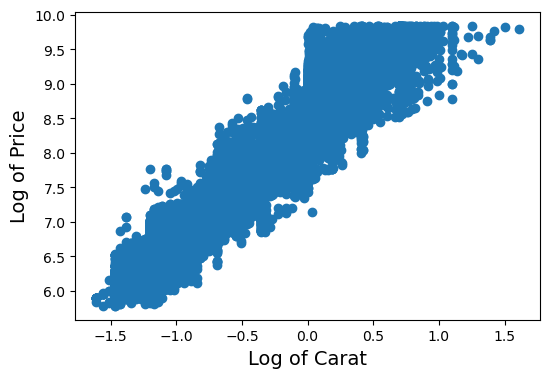


                 sum_sq       df              F  PR(>F)
C(cut)       228.284703      4.0     881.243088     0.0
log_carat  51030.853876      1.0  787973.730176     0.0
Residual    3492.880495  53934.0            NaN     NaN

The null hypothesis is rejected.
Despite of controlling for carat, the price is not the same for each color.
C(cut)[T.Premium]       8.438342
C(cut)[T.Very Good]     8.440878
C(cut)[T.Good]          8.363370
C(cut)[T.Fair]          8.200125
log_carat              10.213108
dtype: float64

These are the marginal means, also known as adjusted means
Note that Premium and Very Good cuts are the most expensive, after removing the effect of carat.


In [83]:
# Compute log of carat
df_data["log_carat"] = np.log(df_data["carat"])

# Plot relationship between dependent variable and covariate
plt.figure(figsize=(6,4))
plt.scatter(x=df_data["log_carat"], y=df_data["log_price"])
plt.xlabel("Log of Carat", fontsize=14)
plt.ylabel("Log of Price", fontsize=14)
plt.show()

# Perform ANCOVA analysis
model = ols(data=df_data, formula="log_price ~ C(cut) + log_carat").fit()

# Compute the adjusted means
adjusted_means = model.params[1:] + model.params['Intercept']

# Output
print("\n"+"="*100)
print(sm.stats.anova_lm(model, typ=2))
print("\nThe null hypothesis is rejected.\nDespite of controlling for carat, the price is not the same for each color.")
print("="*100)
print(adjusted_means)
print("\nThese are the marginal means, also known as adjusted means")
print("Note that Premium and Very Good cuts are the most expensive, after removing the effect of carat."+"\n"+"="*100)